In [1]:
import torch
# 파이토치를 import
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
# 파이토치 라이브러리 안에 있는 Dataset, DataLoader, random_split 학습을 위해서 import
from torchvision import datasets
#CIFA-10데이터셋을 불러오기 위해서 import
import torchvision.transforms as transfroms
# 데이터를 Tensor로 만들어주고 정규화를 위해 import

In [2]:
train_transfrom = transfroms.Compose([
    transfroms.ToTensor()])
# 데이터를 Tensor로 만들어줌

training_data = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=train_transfrom)
#datasets으로부터 MNIST데이터 다운로드
val_split = 10000
train_split = 50000
training_data, val_data = random_split(
    training_data, [train_split, val_split]
)
# 데이터를 학습 데이터와 검증데이터로 나눔 (총 데이터의 수가 50000개이기 떄문에 50000개 10000개로 나눔)
train_dataloader = DataLoader(training_data, shuffle=True, batch_size=32)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=True)
#모델에 data를 넣기 위해서는 DataLoader의 형태가 되야 하므로 DataLoader의 형태로 만들어줌, 데이터의 순서가 섞이게 들어가고 batch_size를 설정해준다.

100%|██████████| 9912422/9912422 [00:00<00:00, 100576259.44it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 113849336.30it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35097852.26it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6510775.38it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# 모델을 직접 만든 이유는 MNIST데이터셋은 복잡한 데이터셋이 아니기 때문에
# 연산량이 많지 않은 간단한 모델로도 다른 복잡한 모델의 정확도와 비교했을 때
# 비슷한 정확도가 나올 수 있다고 생각해서 모델을 새로 만들게 되었다.

# 모델 구성은
# conv16 -> normalize -> conv64 -> normalize ->
# maxpool -> conv128 -> normalize -> flatten -> classifier(linear)
# 이렇게 구성되어있다.
class CustomModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extractor_16 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.feature_extractor_64 = nn.Conv2d(16, 64, kernel_size=3, padding=1)
        self.feature_extractor_128 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # convulution 을 정의해준다 채널의 개수가 1->16->64->128로 정의

        self.norm_16  = nn.BatchNorm2d(16)
        self.norm_64 =  nn.BatchNorm2d(64)
        self.norm_128 =  nn.BatchNorm2d(128)
        # 배치 정규화를 위한 정규화 계층 정의

        self.LeakyReLU = nn.LeakyReLU(0.2)
        # LeakyReLU활성화 함수 정의
        self.MaxPoold = nn.MaxPool2d(2, 2, padding=1)
        # Pooling계층 정의

        torch.nn.init.kaiming_uniform(self.feature_extractor_16.weight)
        torch.nn.init.kaiming_uniform(self.feature_extractor_64.weight)
        torch.nn.init.kaiming_uniform(self.feature_extractor_128.weight)
        # 가중치 초기화 정의
        self.classifier = nn.Linear(28800, 10)
        # 마지막 분류를 위한 Linear계층 정의

    def forward(self, x):
        x = self.feature_extractor_16(x)
        x = self.norm_16(x)
        x = self.feature_extractor_64(x)
        x = self.norm_64(x)
        x = self.MaxPoold(x)
        x = self.feature_extractor_128(x)
        x = self.norm_128(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
import numpy as np
#넘파이 import

# train
trans_model = CustomModel()
# 만든 모델을 정의 한다
device = 'cuda'
trans_model.to(device)
# 모델을 cpu에서 돌리면 시간이 오래 걸림 따라서 cuda를 이용해서 gpu를 이용
train_size = len(train_dataloader.dataset)
# train데이터 길이
train_batch_num = len(train_dataloader)
# batch의 총 개수가 몇개인가
size = len(train_dataloader.dataset)
# batch의 개수
loss_fn = nn.CrossEntropyLoss()
# 손실함수 정의
# 분류임으로 mAP와같은 손실함수가 아닌 분류문제에 일반적으로 쓰이는 CossEntropy함수를 사용하여 손실함수를 정의한다.
optimizer = torch.optim.SGD(trans_model.parameters(), lr=1e-4, weight_decay=0.1, momentum=0.9)
# optimizer 정의
# SGD를 쓴 이유는 모델이 간단하고 데이터셋또한 간단해서 다른 optimizer를 쓰는 것 보다 성능이 좋게 나오는 것으로 판단해서 SGD를 사용
train_loss_list = []
train_acc_list = []
# train의 loss값과 acc값의 진척을 보기 위해 값을 기록할 list생성

#val
val_size = len(val_dataloader.dataset)
num_batches = len(val_dataloader)
# train의 loss값과 acc값의 진척을 보기 위해 값을 기록할 list생성
F_full_images = []
F_full_target = []
val_loss_list = []
val_acc_list = []

for epoch in range(10):
  # epoch값 10번으로 정의
    print(f'[Epoch {epoch}]')
    train_loss = 0
    train_acc = 0
    # train_loss, train_acc값을 담아둘 변수
    for batch, (images, targets) in enumerate(train_dataloader):# train_loader로부터 image, target값을 받아올 반복문
        trans_model.train()
        # 모델을 train으로 정의 eval로 되어있을 경우 배치정규화나 dropout같이 train에 사용되어야하는 기능이 실행이 안됨
        # 그렇기 때문에 train임을 명시해주어 dropout이나 배치정규화를 사용
        images = images.to(device)
        targets = targets.to(device)
        # 받아온 image와 target을 gpu로 보냄

        preds = trans_model(images)
        # training_data를 넣어 예측값 도출
        loss = loss_fn(preds, targets)
        # 예측한 값과 실제의 값을 손실함수를 이용해 loss값 도출
        train_loss += loss.item()
        # train_loss값에 더해줌
        # 더해주는 이유는 지금 배치를 이용한 학습을 하고 있음으로 한 epoch의 모델에 대한 trian_loss값을 측정하기 위해서는 값을 모두 더한 뒤 총 데이터수로 나누어줘야
        # 한 epoch에 대한 loss값이 될 수 있음

        optimizer.zero_grad()
        # 역전파를 하기 전에 optimizer에 남아있는 grad를 0으로 초기화 해줘야 역전파를 했을 때 전에 한 역전파의 영향을 받지 않는다
        loss.backward()
        # 역전파를 한다
        optimizer.step()
        # 매개변수 최적화

        train_acc += (preds.argmax(1) == targets).float().sum().item()
        # 예측한 값과 진짜의 값이 같다면 그 값을 train_acc에 1씩 더해줌
        # 나중에 train_acc값을 데이터의 총 개수로 나누어주는 연산을 이용해 그 모델의 정확도를 측정할 수 있음


        if batch % 10 == 0:
            loss = loss.item()
            current = batch * len(images)
            print(f'epoch:{epoch} loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')
         # 중간중간 loss값과 지금까지 얼마나 되었는지를 출력하기 위한 코드
    train_loss_list.append(train_loss/ train_batch_num)
    # train_loss_list에 epoch이 한번 돌았을 때의 총 loss값을 추가
    #위에서 말한 train_loss를 총 train_batch로 나누어줌으로 epoch 하나당 하나의 trian_loss값이 나올 수 있게 함
    train_acc_list.append(train_acc / train_size)
    # train_acc_list에 epoch이 한번 돌았을 때의 총 acc값을 추가
    # 위에서 말한 train_acc 총 train_size 나누어줌으로 epoch 하나당 하나의 trian_loss값이 나올 수 있게 함


    #val
    with torch.no_grad():
        # val일 때는 gradient 트래킹 멈춤
        batch_loss = 0
        batch_corr = 0
        best_loss = 100000
        trans_model.eval()
        # 모델을 평가하는 형태로 정의
        # eval을 선언해주지 않는다면 평가할 때는 쓰이면 안되는 dropout기법등이 쓰이게 되어 성능이 안좋아질 수 있음
        for test_batch, (images, targets) in enumerate(val_dataloader):# test_loader로부터 image, target값을 받아올 반복문
            images = images.to(device)
            # val데이터를 gpu로 보냄
            targets = targets.to(device)
            # target데이터를 gpu로 보냄

            preds = trans_model(images)
            # model에 val_data넣어서 예측
            batch_loss += loss_fn(preds, targets).item()
            # batch_loss에 batch의 loss값을 계산해 더해줌
            batch_corr +=(preds.argmax(1) == targets).float().sum().item()
            # 예측한 값과 진짜의 값이 같다면 그 값을 batch_corr 1씩 더해줌

            if ((preds.argmax(1) != targets)  and (epoch > 5)):
              #예측 측값이 틀린 것을 찾아서 image로 찍어보기 위한 코드
              #epoch값이 5는 넘어야 model의 학습이 어느정도 진행되었다고 판단하여 epoch의 값이 5를 넘은 시점에만 image저장
                F_full_images.append(images.cpu())
                F_full_target.append(targets.cpu())


            if test_batch % 200 == 0:
                loss = loss_fn(preds, targets).item()
                current = test_batch * len(images)
                print(f'epoch:{epoch} loss: {loss:>7f}  [{current:>5d}/{val_size:>5d}]')
            #중간중간 얼마나 진행되었는지를 보여주기 위한 코드

        val_loss_list.append(batch_loss/num_batches)
        val_acc_list.append(batch_corr/val_size)
        # 검증데이터의 loss값과 acc값의 변화를 보기 위해 list에 추가한다




    print()

<ipython-input-3-7818369d5116>:27: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.feature_extractor_16.weight)
<ipython-input-3-7818369d5116>:28: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.feature_extractor_64.weight)
<ipython-input-3-7818369d5116>:29: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.feature_extractor_128.weight)


[Epoch 0]
epoch:0 loss: 2.640805  [    0/50000]
epoch:0 loss: 1.448431  [  320/50000]
epoch:0 loss: 0.657196  [  640/50000]
epoch:0 loss: 0.993132  [  960/50000]
epoch:0 loss: 0.698550  [ 1280/50000]
epoch:0 loss: 0.311884  [ 1600/50000]
epoch:0 loss: 0.397349  [ 1920/50000]
epoch:0 loss: 0.582164  [ 2240/50000]
epoch:0 loss: 0.563133  [ 2560/50000]
epoch:0 loss: 0.827783  [ 2880/50000]
epoch:0 loss: 0.285347  [ 3200/50000]
epoch:0 loss: 0.231083  [ 3520/50000]
epoch:0 loss: 0.242092  [ 3840/50000]
epoch:0 loss: 0.311616  [ 4160/50000]
epoch:0 loss: 0.240387  [ 4480/50000]
epoch:0 loss: 0.169405  [ 4800/50000]
epoch:0 loss: 0.379380  [ 5120/50000]
epoch:0 loss: 0.297936  [ 5440/50000]
epoch:0 loss: 0.425030  [ 5760/50000]
epoch:0 loss: 0.157295  [ 6080/50000]
epoch:0 loss: 0.075699  [ 6400/50000]
epoch:0 loss: 0.374829  [ 6720/50000]
epoch:0 loss: 0.230629  [ 7040/50000]
epoch:0 loss: 0.382031  [ 7360/50000]
epoch:0 loss: 0.190467  [ 7680/50000]
epoch:0 loss: 0.192959  [ 8000/50000]
ep

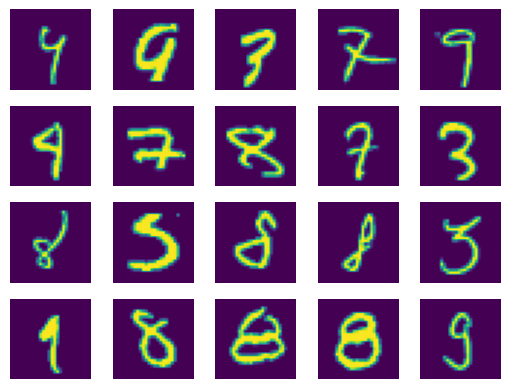

In [5]:
# 예측했는데 틀린 image를 출력하기 위한 코드
import matplotlib.pyplot as plt
# pyplot을 불러오기 위한 코드
fig = plt.figure()
for num, (image, target) in enumerate(zip(F_full_images[-20:], F_full_target[-20:])): # 보여줄 이미지를 20개씩 가져오는 for문
    image = image[0]
    image = np.transpose(image,  (1, 2, 0))
    # 이미지를 찍을 형태로 변환해줌
    ax = fig.add_subplot(4, 5, num+1)
    ax.imshow(image)
    ax.set_label(target)
    plt.axis('off')
    # 이미지를 출력할 때 격자를 꺼주기 위한 코드


Text(0.5, 1.0, 'train_val_accuracy_vgg')

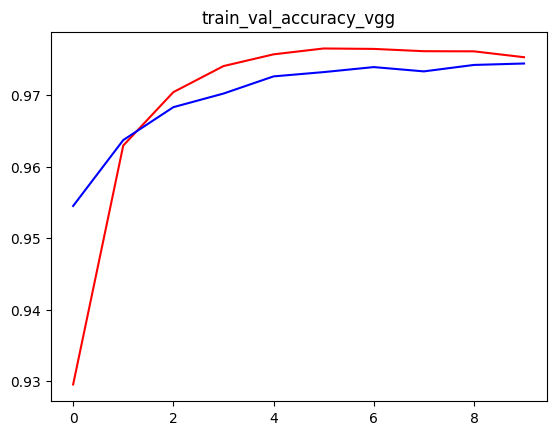

In [6]:
epoch = [num for num in range(10)]
plt.plot(epoch, train_acc_list, color='r')
# epoch에 따른 train데이터의 정확도의 증가를 보는 코드
plt.plot(epoch, val_acc_list, color='b')
# epoch에 따른 val데이터의 정확도 증가를 보는 그래프
plt.title('train_val_accuracy_vgg')
# 정확도를 볼 수 있는 그래프

Text(0.5, 1.0, 'train_val_loss')

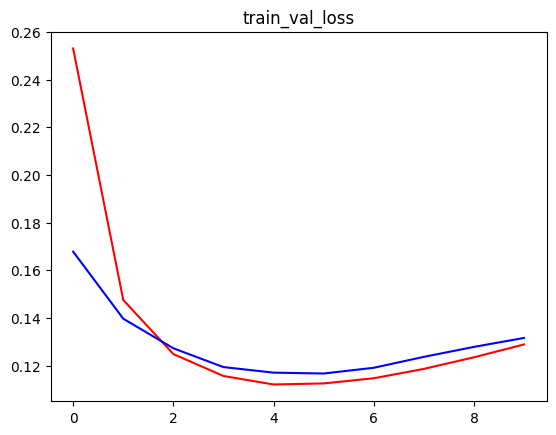

In [7]:
epoch = [num for num in range(10)]
plt.plot(epoch, train_loss_list, color='r')
# epoch에 따른 train데이터의 loss의 감소를 보는 코드
plt.plot(epoch, val_loss_list, color='b')
# epoch에 따른 val데이터의 loss의 감소를 보는 그래프
plt.title('train_val_loss')
# loss값의 감소를 볼 수 있는 코드

In [8]:
print('정확도:'+ str(val_acc_list[-1]))
# 모델의 정확도 출력

정확도:0.9744
